Heart desease dataset
https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn import linear_model, svm, neighbors, naive_bayes, ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

plt.rcParams["figure.figsize"] = (10, 10)

In [2]:
df = pd.read_csv("heart_2020_cleaned.csv")
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [3]:
for col in df:
    print(col, len(df[col].unique()))

HeartDisease 2
BMI 3604
Smoking 2
AlcoholDrinking 2
Stroke 2
PhysicalHealth 31
MentalHealth 31
DiffWalking 2
Sex 2
AgeCategory 13
Race 6
Diabetic 4
PhysicalActivity 2
GenHealth 5
SleepTime 24
Asthma 2
KidneyDisease 2
SkinCancer 2


В исходных данных есть 1 числовой признак, 9 бинарных, 6 категориальных. Бинарные и категориальные, за исключением
трех можно считать номинальными. Целевая переменная бинарная. Преобразуем категориальные признаки к бинарным, для
исаользования моделей, которые не поддерживают наличие категориальных признаков.

In [4]:
num_names = ["BMI"]
cat_names = [x for x in df.columns if x not in num_names and x != "HeartDisease"]

df_cat, df_num = df[cat_names], df[num_names]
d_vec = DictVectorizer(sparse=False)
n_vec = StandardScaler()

x_b = d_vec.fit_transform(df_cat.transpose().to_dict().values())

maping = {
    "Smoking": {"No": 0, "Yes": 1},
    "AlcoholDrinking": {"No": 0, "Yes": 1},
    "Stroke": {"No": 0, "Yes": 1},
    "PhysicalHealth": {v: int(v) for v in df["PhysicalHealth"].unique()},
    "MentalHealth": {v: int(v) for v in df["MentalHealth"].unique()},
    "DiffWalking": {"No": 0, "Yes": 1},
    "Sex": {"Male": 0, "Female": 1},
    "AgeCategory": {v: i for i, v in enumerate(sorted(df["AgeCategory"].unique()))},
    "Race": {v: i for i, v in enumerate(df["Race"].unique())},
    "Diabetic": {"No": 0, "No, borderline diabetes": 1, "Yes": 2, "Yes (during pregnancy)": 3},
    "PhysicalActivity": {"No": 0, "Yes": 1},
    "GenHealth": {"Poor": 0, "Fair": 1, "Good": 2, "Very good": 3, "Excellent": 4},
    "SleepTime": {v: int(v) for v in df["SleepTime"].unique()},
    "Asthma": {"No": 0, "Yes": 1},
    "KidneyDisease": {"No": 0, "Yes": 1},
    "SkinCancer": {"No": 0, "Yes": 1}
}


def vectorize(x):
    m = maping[x.name]
    return np.array([m[v] for v in x])


x_c = df_cat.apply(vectorize).values
x_n = n_vec.fit_transform(df_num.values)
y = df["HeartDisease"].apply(lambda x: 1 if x == "Yes" else 0).values
x_bn = np.concatenate([x_b, x_n], axis=1)
x_cn = np.concatenate([x_c, x_n], axis=1)

Целевая переменная имеет скошенное распределение, поэтому будем пользоваться метрикой f1 для оценки качества модели.

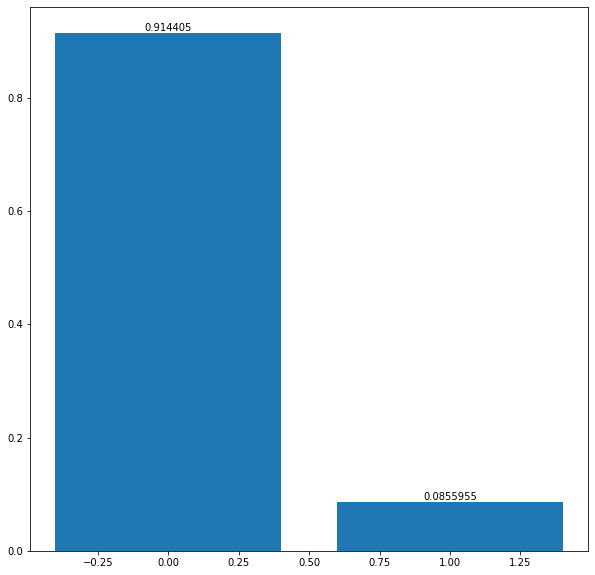

In [5]:
fig, ax = plt.subplots()
bars = ax.bar([0, 1], [(y == 0).sum() / len(y), (y == 1).sum() / len(y)])
ax.bar_label(bars);

Выполним разбиение датасета на подвыборки со стратификацией.

In [ ]:
seed = 42
n_jobs = None
x_bn_train, x_bn_test, x_cn_train, x_cn_test, x_c_train, x_c_test, y_train, y_test = \
    train_test_split(x_bn, x_cn, x_c, y, test_size=0.2, random_state=seed, stratify=y)

In [7]:
def test_model(x_train, x_test, y_train, y_test, model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred, digits=3))
    return f1_score(y_test, y_pred)

scorer = make_scorer(f1_score, zero_division=0)


Обучим различные модели.

In [ ]:
rid_reg = linear_model.RidgeClassifierCV(class_weight="balanced", scoring=scorer)
test_model(x_bn_train, x_bn_test, y_train, y_test, rid_reg)

              precision    recall  f1-score   support

           0      0.973     0.743     0.842     58484
           1      0.221     0.778     0.344      5475

    accuracy                          0.746     63959
   macro avg      0.597     0.761     0.593     63959
weighted avg      0.908     0.746     0.800     63959



0.3439783600468327

In [ ]:
log_reg = linear_model.LogisticRegressionCV(random_state=seed, class_weight="balanced", max_iter=1000, scoring=scorer)
test_model(x_bn_train, x_bn_test, y_train, y_test, log_reg)

              precision    recall  f1-score   support

           0      0.971     0.761     0.853     58484
           1      0.228     0.755     0.351      5475

    accuracy                          0.761     63959
   macro avg      0.600     0.758     0.602     63959
weighted avg      0.907     0.761     0.810     63959



0.350686789893166

In [8]:
parameters = {"C": [1e0, 1e1], "loss": ["hinge", "squared_hinge"], "random_state": [seed], "max_iter": [10000],
              "class_weight": ["balanced"]}
svc = GridSearchCV(svm.LinearSVC(), parameters, scoring=scorer, n_jobs=n_jobs, cv=[(slice(None), slice(None))])
test_model(x_bn_train, x_bn_test, y_train, y_test, svc)

/home/vladimir/programming/mlai/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vladimir/programming/mlai/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vladimir/programming/mlai/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vladimir/programming/mlai/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vladimir/programming/mlai/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.964     0.804     0.876     58484
           1      0.243     0.675     0.358      5475

    accuracy                          0.793     63959
   macro avg      0.604     0.739     0.617     63959
weighted avg      0.902     0.793     0.832     63959



0.35791715060007745

In [9]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights="distance", p=1, algorithm="kd_tree")
test_model(x_bn_train, x_bn_test, y_train, y_test, knn)

              precision    recall  f1-score   support

           0      0.923     0.970     0.946     58484
           1      0.299     0.136     0.187      5475

    accuracy                          0.899     63959
   macro avg      0.611     0.553     0.567     63959
weighted avg      0.870     0.899     0.881     63959



0.18735891647855532

In [ ]:
parameters = {"metric": ["manhattan", "euclidean"]}
knn_centroid = GridSearchCV(neighbors.NearestCentroid(), parameters, scoring=scorer, n_jobs=n_jobs,
                            cv=[(slice(None), slice(None))])
test_model(x_bn_train, x_bn_test, y_train, y_test, knn_centroid)

              precision    recall  f1-score   support

           0      0.933     0.858     0.894     58484
           1      0.184     0.342     0.239      5475

    accuracy                          0.814     63959
   macro avg      0.558     0.600     0.567     63959
weighted avg      0.869     0.814     0.838     63959



0.23921368394179215

In [ ]:
mn_nb = naive_bayes.MultinomialNB()
test_model(x_c_train, x_c_test, y_train, y_test, mn_nb)

              precision    recall  f1-score   support

           0      0.934     0.891     0.912     58484
           1      0.218     0.324     0.260      5475

    accuracy                          0.842     63959
   macro avg      0.576     0.607     0.586     63959
weighted avg      0.872     0.842     0.856     63959



0.26025688073394493

In [ ]:
c_nb = naive_bayes.ComplementNB()
test_model(x_c_train, x_c_test, y_train, y_test, c_nb)

              precision    recall  f1-score   support

           0      0.939     0.854     0.894     58484
           1      0.207     0.408     0.274      5475

    accuracy                          0.815     63959
   macro avg      0.573     0.631     0.584     63959
weighted avg      0.876     0.815     0.841     63959



0.27444232778221594

In [ ]:
k = len(x_b)
b_nb = naive_bayes.BernoulliNB()
test_model(x_bn_train[: k], x_bn_test[: k], y_train, y_test, b_nb)

              precision    recall  f1-score   support

           0      0.949     0.887     0.917     58484
           1      0.287     0.487     0.361      5475

    accuracy                          0.853     63959
   macro avg      0.618     0.687     0.639     63959
weighted avg      0.892     0.853     0.869     63959



0.36139519133085

In [ ]:
c_nb = naive_bayes.CategoricalNB()
test_model(x_c_train, x_c_test, y_train, y_test, c_nb)

              precision    recall  f1-score   support

           0      0.943     0.920     0.932     58484
           1      0.324     0.407     0.361      5475

    accuracy                          0.876     63959
   macro avg      0.633     0.664     0.646     63959
weighted avg      0.890     0.876     0.883     63959



0.3606371795908466

In [ ]:
parameters = {"criterion": ["gini", "entropy"], "random_state": [seed], "class_weight": ["balanced"]}
dt = GridSearchCV(DecisionTreeClassifier(), parameters, scoring=scorer, n_jobs=n_jobs, cv=[(slice(None), slice(None))])
test_model(x_bn_train, x_bn_test, y_train, y_test, dt)

              precision    recall  f1-score   support

           0      0.927     0.924     0.926     58484
           1      0.219     0.227     0.223      5475

    accuracy                          0.864     63959
   macro avg      0.573     0.576     0.574     63959
weighted avg      0.867     0.864     0.866     63959



0.22301836094939548

In [ ]:
parameters = {"criterion": ["gini", "entropy"], "random_state": [seed], "class_weight": ["balanced"],
              "n_estimators": [10, 50, 100, 200]}
rf = GridSearchCV(ensemble.RandomForestClassifier(), parameters, scoring=scorer, n_jobs=n_jobs,
                  cv=[(slice(None), slice(None))])
test_model(x_bn_train, x_bn_test, y_train, y_test, rf)

              precision    recall  f1-score   support

           0      0.922     0.973     0.947     58484
           1      0.295     0.123     0.173      5475

    accuracy                          0.900     63959
   macro avg      0.609     0.548     0.560     63959
weighted avg      0.868     0.900     0.880     63959



0.17320598864223025

In [ ]:
parameters = {"learning_rate": [0.1, 1.0], "random_state": [seed], "max_iter": [10, 50, 100, 200],
              "categorical_features": [1] * x_c.shape[1] + [0] * x_n.shape[1]}
hgbc = GridSearchCV(ensemble.HistGradientBoostingClassifier(), parameters, scoring=scorer, n_jobs=n_jobs,
                    cv=[(slice(None), slice(None))])
test_model(x_cn_train, x_cn_test, y_train, y_test, hgbc)

              precision    recall  f1-score   support

           0      0.922     0.987     0.953     58484
           1      0.430     0.102     0.165      5475

    accuracy                          0.912     63959
   macro avg      0.676     0.545     0.559     63959
weighted avg      0.879     0.912     0.886     63959



0.16504281074697372

In [ ]:
parameters = {"learning_rate": [0.1, 1.0], "random_state": [seed], "n_estimators": [10, 50, 100, 200]}
abc = GridSearchCV(ensemble.AdaBoostClassifier(), parameters, scoring=scorer, n_jobs=n_jobs,
                   cv=[(slice(None), slice(None))])
test_model(x_cn_train, x_cn_test, y_train, y_test, abc)

              precision    recall  f1-score   support

           0      0.924     0.990     0.956     58484
           1      0.551     0.129     0.209      5475

    accuracy                          0.916     63959
   macro avg      0.737     0.560     0.583     63959
weighted avg      0.892     0.916     0.892     63959



0.20943647389439435

In [ ]:
parameters = {"learning_rate": [0.1, 1.0], "random_state": [seed], "n_estimators": [10, 50, 100, 200]}
gbc = GridSearchCV(ensemble.GradientBoostingClassifier(), parameters, scoring=scorer, n_jobs=n_jobs,
                   cv=[(slice(None), slice(None))])
test_model(x_cn_train, x_cn_test, y_train, y_test, gbc)

              precision    recall  f1-score   support

           0      0.924     0.988     0.955     58484
           1      0.504     0.131     0.208      5475

    accuracy                          0.915     63959
   macro avg      0.714     0.560     0.581     63959
weighted avg      0.888     0.915     0.891     63959



0.2081159420289855

In [14]:
parameters = {"hidden_layer_sizes": [(64, ), (128, ), (128, 64)], "activation": ["relu"], "batch_size": [256],
              "early_stopping": [True], "random_state": [seed]}
mlp = GridSearchCV(MLPClassifier(), parameters, scoring=scorer, n_jobs=n_jobs, cv=[(slice(None), slice(None))])
test_model(x_bn_train, x_bn_test, y_train, y_test, mlp)

              precision    recall  f1-score   support

           0      0.921     0.994     0.956     58484
           1      0.577     0.094     0.162      5475

    accuracy                          0.917     63959
   macro avg      0.749     0.544     0.559     63959
weighted avg      0.892     0.917     0.888     63959



0.1617462311557789

Лучший результат показали модели Байесовских классификаторов. Скорее всего из-за того, что напрямую учитывают
распределение категориальных признаков(16 из всех 17) внутри каждого значения бинарной целевой перемнной. На
следующем месте расположились линейные модели. Метрические, ансамблевые модели и персептрон показали худший
результат. Было замечено, что модели с штрафом, обратно пропорциональным размеру классов, модели дают существенно лучшие результаты.
Для улучшения качества классификации возможно стоит попробовать глубокие модели, для категориальных признаков обучать
 ембеддинги. Также стоит попробовать алгоритмы обнаружения аномалий.
